# mlos_bench SQLite data analysis (Teacher's copy)

In this notebook, we look at the data from 100 trials we ran in `mlos_bench` to find a better SQLite configuration.

### 1. Data collection

We used the following commands in the integrated terminal of this codespace:

```sh
conda activate mlos

mlos_bench --config config/cli/local-sqlite-opt.jsonc \
           --globals config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc \
           --trial-config-repeat-count 3 \
           --max-iterations 100
```

> See Also: [README.md](./README.md) for further instructions.

Now we can start analyzing the autotuning data produced by running the benchmark trials.

### 2. Import MLOS packages

In [1]:
# Import mlos_bench Storage API to access the experimental data.
from mlos_bench.storage import from_config

### 3. Connect to the DB using existing mlos_bench configs

In [2]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 4. Load the data for our experiment

In [3]:
storage.experiments

{'mysql-innodb-bseries-v346-vmcontrol': Experiment :: mysql-innodb-bseries-v346-vmcontrol: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-buf': Experiment :: mysql-innodb-buf: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-explore-D2S': Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root',
 'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

We see a record for our experiment in the DB. Let's look at the data associated with it.

In [4]:
experiment_id = "sqlite-sync-journal-pagesize-caching-experiment"
#experiment_id = "sqlite-opt-demo"

### 5. Get all data for one experiment

In [5]:
exp = storage.experiments[experiment_id]

In [6]:
# Display the set of optimization target objectives.
display(exp.objectives)

{'90th Percentile Latency (microseconds)': 'min'}

Main method that combines the information about each trial along with the trial configuration parameters and its results, is the property `.results`. It conveniently returns all data about the experiment is a single Pandas DataFrame.

In [7]:
# View some of the result data associated with that experiment.
df = exp.results_df
df.head()

,trial_id,ts_start,ts_end,tunable_config_id,tunable_config_trial_group_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,...,result.Socket messages received,result.Socket messages sent,result.Swaps,result.System time (seconds),result.Throughput (requests/second),result.User time (seconds),result.Voluntary context switches,result.isolation,result.scalefactor,result.terminals
0,0,2023-10-12 00:19:35.179108,2023-10-12 00:21:32.101952,1,0,SUCCEEDED,1,delete,-1,-1,...,0,0,0,0.33,6.699841,2.81,14577,TRANSACTION_SERIALIZABLE,1,1
1,1,2023-10-12 00:21:32.201016,2023-10-12 00:21:46.432367,2,1,SUCCEEDED,1656398469,truncate,1633227268,363162755,...,0,0,0,0.28,31.099798,3.37,14950,TRANSACTION_SERIALIZABLE,1,1
2,2,2023-10-12 00:21:46.494138,2023-10-12 00:22:00.870337,3,2,SUCCEEDED,1281136238,off,704594,779126884,...,0,0,0,0.34,63.598733,3.76,15210,TRANSACTION_SERIALIZABLE,1,1
3,3,2023-10-12 00:22:00.936280,2023-10-12 00:22:15.337492,4,3,SUCCEEDED,948829517,wal,1120228729,1951308613,...,0,0,0,0.32,63.094578,3.77,14829,TRANSACTION_SERIALIZABLE,1,1
4,4,2023-10-12 00:22:15.397273,2023-10-12 00:22:31.124095,5,4,SUCCEEDED,699030920,persist,2027784438,2120909557,...,0,0,0,2.95,1440.387481,13.27,12883,TRANSACTION_SERIALIZABLE,1,1


Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). The `trial_id` field is simply the iteration number within the current experiment. Let's look at the first record to see all these fields.

In [8]:
df.loc[1]

trial_id                                                                                              1
ts_start                                                                     2023-10-12 00:21:32.201016
ts_end                                                                       2023-10-12 00:21:46.432367
tunable_config_id                                                                                     2
tunable_config_trial_group_id                                                                         1
status                                                                                        SUCCEEDED
config.cache_size                                                                            1656398469
config.journal_mode                                                                            truncate
config.journal_size_limit                                                                    1633227268
config.mmap_size                                                

### 6. Visualize the results data automatically using `mlos_viz.plot()`

In [11]:
import mlos_viz

`mlos_viz` attempts to use the information about the data to automatically provide some basic visualizations without much effort on the developer's part.

At the moment, we do this using [`dabl`](https://github.com/dabl/dabl), though in the future we intend to add support for more interactive visualizations or even scheduling new trials, while maintaining a very simple API:

In [27]:
from typing import Optional, Iterable, Union, Literal
import re
import pandas
from pandas.api.types import is_numeric_dtype
from mlos_bench.storage.base_experiment_data import ExperimentData

def augment_results_df_with_config_trial_group_stats(exp_data: Optional[ExperimentData] = None,
                                                     *,
                                                     results_df: Optional[pandas.DataFrame] = None,
                                                     requested_result_cols: Optional[Iterable[str]] = None,
                                                     ) -> pandas.DataFrame:
    # pylint: disable=too-complex
    """
    Add a number of useful statistical measure columns to the results dataframe.

    In particular, for each numeric result, we add the following columns:
        ".p50" - the median of each config trial group results
        ".p75" - the p75 of each config trial group results
        ".p90" - the p90 of each config trial group results
        ".p95" - the p95 of each config trial group results
        ".p99" - the p95 of each config trial group results
        ".mean" - the mean of each config trial group results
        ".stddev" - the mean of each config trial group results
        ".var" - the variance of each config trial group results
        ".var_zscore" - the zscore of this group (i.e., variance relative to the stddev of all group variances)
            This can be useful for filtering out outliers
            (e.g., configs with high variance relative to others by restricting to abs <= 2)

    Parameters
    ----------
    exp_data : ExperimentData
        The ExperimentData (e.g., obtained from the storage layer) to plot.
    results_df : Optional[pandas.DataFrame]
        The results dataframe to augment, by default None to use the results_df property.
    requested_result_cols : Optional[Iterable[str]]
        Which results columns to augment, by default None to use all results columns.

    Returns
    -------
    pandas.DataFrame
        The augmented results dataframe.
    """
    if results_df is None:
        if exp_data is None:
            raise ValueError("Either exp_data or results_df must be provided.")
        results_df = exp_data.results_df
    results_groups = results_df.groupby("tunable_config_id")
    if len(results_groups) <= 1:
        raise ValueError(f"Not enough data: {len(results_groups)}")

    if requested_result_cols is None:
        result_cols = set(col for col in results_df.columns if col.startswith(ExperimentData.RESULT_COLUMN_PREFIX))
    else:
        result_cols = set(col for col in requested_result_cols
                          if col.startswith(ExperimentData.RESULT_COLUMN_PREFIX) and col in results_df.columns)
        result_cols.update(set(ExperimentData.RESULT_COLUMN_PREFIX + col for col in requested_result_cols
                               if ExperimentData.RESULT_COLUMN_PREFIX in results_df.columns))

    def compute_zscore_for_group_agg(
            results_groups_perf: "SeriesGroupBy",
            stats_df: pandas.DataFrame,
            result_col: str,
            agg: Union[Literal["mean"], Literal["var"], Literal["std"]]
    ) -> None:
        results_groups_perf_aggs = results_groups_perf.agg(agg)    # TODO: avoid recalculating?
        # Compute the zscore of the chosen aggregate performance of each group into each row in the dataframe.
        stats_df[result_col + f".{agg}_mean"] = results_groups_perf_aggs.mean()
        stats_df[result_col + f".{agg}_stddev"] = results_groups_perf_aggs.std()
        stats_df[result_col + f".{agg}_zscore"] = \
            (stats_df[result_col + f".{agg}"] - stats_df[result_col + f".{agg}_mean"]) \
            / stats_df[result_col + f".{agg}_stddev"]
        stats_df.drop(columns=[result_col + ".var_" + agg for agg in ("mean", "stddev")], inplace=True)

    augmented_results_df = results_df
    augmented_results_df["tunable_config_trial_group_size"] = results_groups["trial_id"].transform("count")
    for result_col in result_cols:
        if not result_col.startswith(ExperimentData.RESULT_COLUMN_PREFIX):
            continue
        if re.search(r"(start|end).*time", result_col, flags=re.IGNORECASE):
            # Ignore computing variance on things like that look like timestamps.
            continue
        if not is_numeric_dtype(results_df[result_col]):
            continue
        if results_df[result_col].unique().size == 1:
            continue
        results_groups_perf = results_groups[result_col]
        stats_df = pandas.DataFrame()
        stats_df[result_col + ".mean"] = results_groups_perf.transform("mean", numeric_only=True)
        stats_df[result_col + ".var"] = results_groups_perf.transform("var")
        stats_df[result_col + ".stddev"] = stats_df[result_col + ".var"].apply(lambda x: x**0.5)

        compute_zscore_for_group_agg(results_groups_perf, stats_df, result_col, "var")
        quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
        for quantile in quantiles:     # TODO: can we do this in one pass?
            quantile_col = result_col + f".p{int(quantile*100)}"
            stats_df[quantile_col] = results_groups_perf.transform("quantile", quantile)
        augmented_results_df = pandas.concat([augmented_results_df, stats_df], axis=1)
    return augmented_results_df

cols = [col for col in df.columns if col.startswith("result.90th")] + ["trial_id", "tunable_config_id", "tunable_config_trial_group_id", "tunable_config_trial_group_size"]

display(augment_results_df_with_config_trial_group_stats(exp)[cols])

,result.90th Percentile Latency (microseconds),trial_id,tunable_config_id,tunable_config_trial_group_id,tunable_config_trial_group_size
0,306662,0,1,0,1
1,40363,1,2,1,1
2,20173,2,3,2,1
3,19680,3,4,3,1
4,1306,4,5,4,1
...,...,...,...,...,...
95,995,95,96,95,1
96,1015,96,97,96,1
97,1432,97,98,97,1
98,1077,98,99,98,1


In [31]:
from typing import Optional, Literal, List, Dict, Tuple
import pandas
from mlos_bench.storage.base_experiment_data import ExperimentData
from mlos_viz.util import expand_results_data_args

def limit_top_n_configs(exp_data: Optional[ExperimentData] = None,
                        *,
                        results_df: Optional[pandas.DataFrame] = None,
                        objectives: Optional[Dict[str, Literal["min", "max"]]] = None,
                        top_n_configs: int = 10,
                        method: Literal["mean", "p50", "p75", "p90", "p95", "p99"] = "mean",
                        ) -> Tuple[pandas.DataFrame, List[int], Dict[str, bool]]:
    # pylint: disable=too-many-locals
    """
    Utility function to process the results and determine the best performing
    configs including potential repeats to help assess variability.

    Parameters
    ----------
    exp_data : Optional[ExperimentData]
        The ExperimentData (e.g., obtained from the storage layer) to operate on.
    results_df : Optional[pandas.DataFrame]
        The results dataframe to augment, by default None to use the results_df property.
    objectives : Iterable[str], optional
        Which result column(s) to use for sorting the configs, and in which direction ("min" or "max").
        By default None to automatically select the experiment objectives.
    top_n_configs : int, optional
        How many configs to return, including the default, by default 20.
    method: Literal["mean", "median", "p50", "p75", "p90", "p95", "p99"] = "mean",
        Which statistical method to use when sorting the config groups before determining the cutoff, by default "mean".

    Returns
    -------
    (top_n_config_results_df, top_n_config_ids, orderby_cols) : Tuple[pandas.DataFrame, List[int], Dict[str, bool]]
        The filtered results dataframe, the config ids, and the columns used to order the configs.
    """
    # Do some input checking first.
    if method not in ["mean", "p50", "p75", "p90", "p95", "p99"]:
        raise ValueError(f"Invalid method: {method}")

    # Prepare the orderby columns.
    (results_df, objs_cols) = expand_results_data_args(exp_data, results_df=results_df, objectives=objectives)
    assert isinstance(results_df, pandas.DataFrame)

    # Augment the results dataframe with some useful stats.
    results_df = augment_results_df_with_config_trial_group_stats(
        exp_data=exp_data,
        results_df=results_df,
        requested_result_cols=objs_cols.keys(),
    )
    # Note: mypy seems to lose its mind for some reason and keeps forgetting that
    # results_df is not None and is in fact a DataFrame, so we periodically assert
    # it in this func for now.
    assert results_df is not None
    orderby_cols: Dict[str, bool] = {obj_col + f".{method}": ascending for (obj_col, ascending) in objs_cols.items()}

    config_id_col = "tunable_config_id"
    group_id_col = "tunable_config_trial_group_id"     # first trial_id per config group
    trial_id_col = "trial_id"

    default_config_id = results_df[trial_id_col].min() if exp_data is None else exp_data.default_tunable_config_id
    assert default_config_id is not None, "Failed to determine default config id."

    # Filter out configs whose variance is too large.
    # But also make sure the default configs is still in the resulting dataframe
    # (for comparison purposes).
    display(objs_cols)
    for obj_col in objs_cols:
        assert results_df is not None
        if method == "mean":
            singletons_mask = results_df["tunable_config_trial_group_size"] == 1
        else:
            singletons_mask = results_df["tunable_config_trial_group_size"] > 1
        results_df = results_df.loc[(
            (results_df[f"{obj_col}.var_zscore"].abs() < 2)
            | (singletons_mask)
            | (results_df[config_id_col] == default_config_id)
        )]
    assert results_df is not None

    # Also, filter results that are worse than the default.
    default_config_results_df = results_df.loc[results_df[config_id_col] == default_config_id]
    for (orderby_col, ascending) in orderby_cols.items():
        default_vals = default_config_results_df[orderby_col].unique()
        assert len(default_vals) == 1
        default_val = default_vals[0]
        assert results_df is not None
        if ascending:
            results_df = results_df.loc[(results_df[orderby_col] <= default_val)]
        else:
            results_df = results_df.loc[(results_df[orderby_col] >= default_val)]
            
    # Now regroup and filter to the top-N configs by their group performance dimensions.
    assert results_df is not None
    group_results_df: pandas.DataFrame = results_df.groupby(config_id_col).first()[orderby_cols.keys()]
    top_n_config_ids: List[int] = group_results_df.sort_values(
        by=list(orderby_cols.keys()), ascending=list(orderby_cols.values())).head(top_n_configs).index.tolist()

    # Remove the default config if it's included. We'll add it back later.
    if default_config_id in top_n_config_ids:
        top_n_config_ids.remove(default_config_id)
    # Get just the top-n config results.
    # Sort by the group ids.
    top_n_config_results_df = results_df.loc[(
        results_df[config_id_col].isin(top_n_config_ids)
    )].sort_values([group_id_col, config_id_col, trial_id_col])
    # Place the default config at the top of the list.
    top_n_config_ids.insert(0, default_config_id)
    top_n_config_results_df = pandas.concat([default_config_results_df, top_n_config_results_df], axis=0)
    return (top_n_config_results_df, top_n_config_ids, orderby_cols)

display(limit_top_n_configs(exp, top_n_configs=10, method="mean")[0])

{'result.90th Percentile Latency (microseconds)': True}

,trial_id,ts_start,ts_end,tunable_config_id,tunable_config_trial_group_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,...,tunable_config_trial_group_size,result.90th Percentile Latency (microseconds).mean,result.90th Percentile Latency (microseconds).var,result.90th Percentile Latency (microseconds).stddev,result.90th Percentile Latency (microseconds).var_zscore,result.90th Percentile Latency (microseconds).p50,result.90th Percentile Latency (microseconds).p75,result.90th Percentile Latency (microseconds).p90,result.90th Percentile Latency (microseconds).p95,result.90th Percentile Latency (microseconds).p99
0,0,2023-10-12 00:19:35.179108,2023-10-12 00:21:32.101952,1,0,SUCCEEDED,1,delete,-1,-1,...,1,306662.0,NaN,NaN,NaN,306662.0,306662.0,306662.0,306662.0,306662.0


In [9]:
from mlos_viz.base import limit_top_n_configs
display(limit_top_n_configs(exp, top_n_configs=10)[0])

,trial_id,ts_start,ts_end,tunable_config_id,tunable_config_trial_group_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,...,result.terminals,result.90th Percentile Latency (microseconds).mean,result.90th Percentile Latency (microseconds).var,result.90th Percentile Latency (microseconds).stddev,result.90th Percentile Latency (microseconds).var_zscore,result.90th Percentile Latency (microseconds).p50,result.90th Percentile Latency (microseconds).p75,result.90th Percentile Latency (microseconds).p90,result.90th Percentile Latency (microseconds).p95,result.90th Percentile Latency (microseconds).p99
0,0,2023-10-12 00:19:35.179108,2023-10-12 00:21:32.101952,1,0,SUCCEEDED,1,delete,-1,-1,...,1,306662.0,NaN,NaN,NaN,306662.0,306662.0,306662.0,306662.0,306662.0


In [10]:
mlos_viz.plot(exp)

NameError: name 'mlos_viz' is not defined

# TODO: Write up take away texts to go along with these graphs.

### 7. Alternatively, plot the results manually using `seaborn` and `matplotlib`.

In [ ]:
# Import a few popular third-party packages for data analysis. They come pre-installed with Anaconda.
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Cosmetic: Suppress some annoying warnings from third-party data visualization packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

First, let's select some configuration parameters and benchmark metrics to analyze.

In [ ]:
# Categorical tunable to consider:
CATEGORY = "config.synchronous"

# A system resource metric to analyze.
METRIC = "result.File system outputs"

# Which performance metric to plot on the Y-axis.
SCORE = "result.90th Percentile Latency (microseconds)"

#### 7.1. Plot the behavior of the optimizer

First, let's see how the optimizer converges to a new optimal SQLite configuration.

We will plot the iteration number on the X axis and the optimization target on the Y. Each dot of the scatterplot represents the performance of the configuration that the optimizer proposes for that trial.
The line plot shows the best configuration found so far (that is, a cumulative minimum of the score).

As we can see, the optimizer does not necessarily take a direct path to the optimal configuration.
It may try some configurations that are worse than the current best one.
This is expected, as the optimizer is trying to explore the configuration space and find the global optimum, not just the local one.
There may also be some noise in the system that can lead to some config regions reporting variance in their performance.

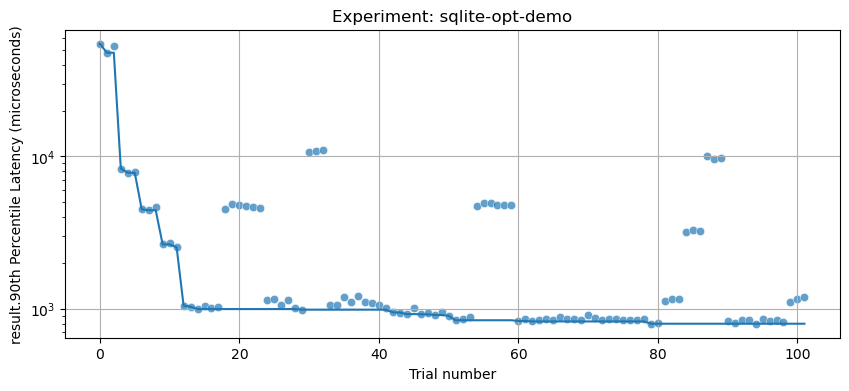

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4)

sns.scatterplot(x=df.trial_id, y=df[SCORE], alpha=0.7)  # Result of each trial
sns.lineplot(x=df.trial_id, y=df[SCORE].cummin())  # the best result so far (cummin)

plt.yscale('log')

plt.xlabel("Trial number")
plt.ylabel(SCORE)

plt.title("Experiment: " + exp.experiment_id)
plt.grid()
plt.show()

We see that the optimizer finds a good configuration in about 10 interations. After that, it oscillates between exploring some remote areas of the configuration space (and getting some pretty bad banchmarking results) and exploiting the neighborhoods of the well-performing configurations, further improving the results.

#### 7.2. Plot the results of one metric vs. another for some tunable

The intent is to explore parameter importance and impact on different metrics (both application performance and system resource usage).

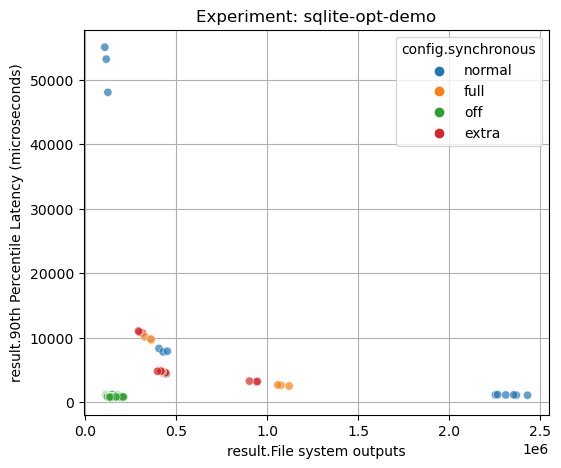

In [ ]:
plt.rcParams["figure.figsize"] = (6, 5)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.title("Experiment: " + exp.experiment_id)
plt.grid()
plt.show()

The results are here, but the outliers make it really difficult to understand what's going on. Let's switch to the log scale and see if that helps.

#### 7.3. Plot on log scale

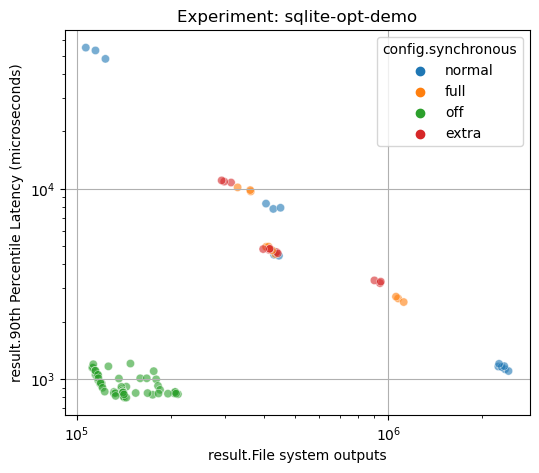

In [ ]:
plt.rcParams["figure.figsize"] = (6, 5)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.6)

plt.xscale('log')
plt.yscale('log')

plt.title("Experiment: " + exp.experiment_id)
plt.grid()
plt.show()

 Now we can see that setting `synchronous=off` seems to improve the latency a lot. Apparently, the optimizer had also noticed that and focused on exploring a particular area of the configuration space. Let's switch back to the linear scale and zoom in to that region.

#### 7.4. Zoom in

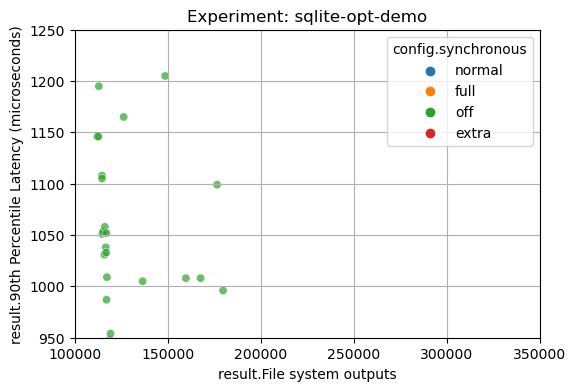

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.xlim(100000, 350000)
plt.ylim(950, 1250)

plt.title("Experiment: " + exp.experiment_id)
plt.grid()
plt.show()

The latency seems to be minimal when the configuration parameter `synchronous` is set to `off` and when the metric `File system outputs` is in range of 100..300K. Let's focus on that subset of data and see what other configuration settings get us there.

#### 7.5. Look at other configuration parameters

In [ ]:
df_lim = df[(df[CATEGORY] == "off") & (df[METRIC] > 100000) & (df[METRIC] < 300000)]

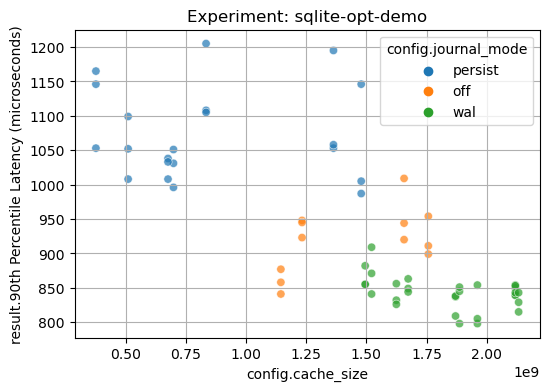

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)

sns.scatterplot(data=df_lim, x="config.cache_size", y=SCORE, hue="config.journal_mode", marker='o', alpha=0.7)

plt.title("Experiment: " + exp.experiment_id)
plt.grid()
plt.show()

Again, we see that setting `journal_mode` to `wal` and `cache_size` to the value between 500MB and 2GB seem to produce good results, but we need more experiments to explore that hypothesis.

### 8. Outro

If you feel curious, please go ahead and play with the SQLite data in the cells below.

After that, please open other notebooks in this repository and explore the data you have collected in this class as well as the results from our MySQL optimization experiments:

* [**mlos_demo_sqlite.ipynb**](mlos_demo_sqlite.ipynb) - Use this notebook to analyze the data you've collected during this workshop.
* [**mlos_demo_mysql.ipynb**](mlos_demo_mysql.ipynb) - Look at the actual production data we've collected in serveral experiment for MySQL Server optimization on Azure.